**Packages**

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F# define NN architecture

import matplotlib.pyplot as plt


**Data Loading**

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 1
# percentage of training set to use as validation
valid_size = 0.2# convert data to torch.FloatTensor
transform = transforms.ToTensor()# choose the training and testing datasets
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

100%|██████████| 9912422/9912422 [00:00<00:00, 88433935.17it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18429285.54it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46425349.05it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15301629.53it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



**Generator Model**

In [3]:
import torch.nn as nn
import torch.nn.functional as F# define NN architecture
class Generator(nn.Module):
    def __init__(self,noise=100):                   # noise size = 100
        super(Generator,self).__init__()
        # linear layer (100 -> hidden_1)
        self.fc1 = nn.Linear(noise, 256)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(256,512)
        # linear layer (n_hidden -> 784)
        self.fc3 = nn.Linear(512,28*28)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)

    def forward(self,x):
        # flatten image input
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        #x = x.reshape(28*28)
        return x             # initialize the NN

gen = Generator()

print(gen)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


**Gaussian Distribution N(0,1)**

In [4]:
def get_z_random(batchSize, nz):
        z = np.random.normal(0, 1, (batchSize,nz))
        z = torch.Tensor(z)
        return z

**Reconstruction LOSS = Mean Squared Error**

In [5]:
criterion_G = nn.MSELoss()
criterion_G2 = nn.L1Loss()
optimizer_G = torch.optim.SGD(gen.parameters(),lr = 0.1)     # can change the learning rate value -> lr = 0.01

In [6]:
# number of epochs to train the model
n_epochs = 1  # initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity

flag = 0

list_loss = []
cont = 0

for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0

    ###################
    # train the model #
    ###################

    gen.train()                                # prep model for training

    for data,label in train_loader:
        cont+=1
        if(flag==0):                           # FLAG to randomic selection
            target = data                      # We want to reconstruction a single NUMBER at a time
            label_target = label
            real = target.reshape((28,28))
            plt.imshow(real, cmap='gray')
            plt.show()
            flag = 1

        # clear the gradients of all optimized variables
        optimizer_G.zero_grad()
        nz = get_z_random(batch_size,100)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = gen(nz)
        img = output = output.reshape((28,28))   # resize output image
        output = output.unsqueeze(0)
        output = output.unsqueeze(1)

        # calculate the loss
        loss_1 = criterion_G(output,target)
        loss_2 = criterion_G2(output,target)

        loss = loss_1 + loss_2
        # save loss values
        list_loss.append(loss.detach().numpy())

        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer_G.step()

        # update running training loss
        img = img.detach().numpy()

        #fig.add_subplot(1, 2, 1) #fig, axs = plt.subplots(1, 2)
        plt.title(' Itter: %d Label Target:%d MSE: %f'%(cont,label_target.detach().numpy(),loss.detach().numpy()))
        plt.imshow(img, cmap='gray')
        plt.show()
        plt.cla()
        plt.close("all")



Output hidden; open in https://colab.research.google.com to view.

<ipython-input-1-5dcbddd779c8>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


NameError: name 'list_loss' is not defined

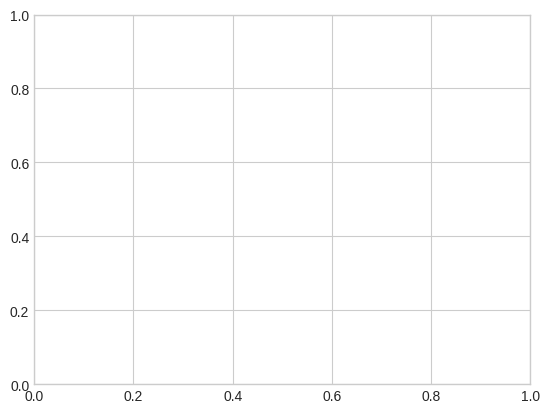

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, len(list_loss), len(list_loss))
ax.plot(x, list_loss);